In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
#from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import math


In [2]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU name: NVIDIA A100-PCIE-40GB 



# Load MNIST dataset


In [3]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

In [4]:
from collections import defaultdict
from torch.utils.data import Subset
import numpy as np

# Group indices of each digit in the training dataset
digit_indices = defaultdict(list)
for idx, (image, label) in enumerate(training_dataset):
    digit_indices[label].append(idx)

# Stratify split by digits
train_indices = []
val_indices = []

for digit, indices in digit_indices.items():
    np.random.shuffle(indices)  # Shuffle indices for each digit
    split = int(0.8 * len(indices))  # 80% training, 20% validation
    train_indices.extend(indices[:split])
    val_indices.extend(indices[split:])

# Create Subset datasets for training and validation
train_dataset = Subset(training_dataset, train_indices)
val_dataset = Subset(training_dataset, val_indices)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Optional: Verify the distribution of digits
train_digit_counts = defaultdict(int)
val_digit_counts = defaultdict(int)

for _, label in train_dataset:
    train_digit_counts[label] += 1

for _, label in val_dataset:
    val_digit_counts[label] += 1

print("Training digit distribution:", dict(train_digit_counts))
print("Validation digit distribution:", dict(val_digit_counts))

Training set size: 47995
Validation set size: 12005
Training digit distribution: {5: 4336, 0: 4738, 4: 4673, 1: 5393, 9: 4759, 2: 4766, 3: 4904, 6: 4734, 7: 5012, 8: 4680}
Validation digit distribution: {5: 1085, 0: 1185, 4: 1169, 1: 1349, 9: 1190, 2: 1192, 3: 1227, 6: 1184, 7: 1253, 8: 1171}


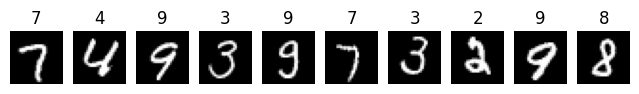

In [5]:
# show 10 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='gray')
    ax.set_title(int(training_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

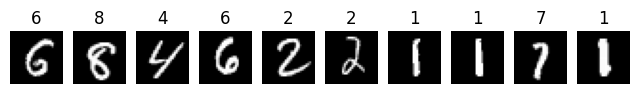

In [6]:
# show 10 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='gray')
    ax.set_title(int(test_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

# Define dataloaders


In [7]:
training_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True) # train_dataset is the split training dataset
validation_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

# Define Linear_Variance_Scheduler


In [8]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start=0.0001, beta_end=0.02, device='cuda'):
        
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        
    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    # Reverse process
    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

In [9]:
class Cosine_Variance_Scheduler:
    def __init__(self, time_steps, s=0.008, start=0, end=1, tau=1, clip_min=1e-9, device='cuda'):
        self.time_steps = time_steps
        self.device = device

        # Generate alpha_bar values using cosine_schedule function
        self.alpha_bar = [self.cosine_schedule(t, time_steps, s) for t in range(time_steps)]
        self.alpha_bar = torch.tensor(self.alpha_bar, dtype=torch.float32).to(self.device)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

        # Generate betas
        self.betas_minus_0 = 1 - (self.alpha_bar[1:] / self.alpha_bar[:-1])
        self.beta_0 = torch.tensor(1 - math.cos(s * (math.pi / 2) / (1 + s)) ** 2, dtype=torch.float32)
        self.beta_0 = self.beta_0.unsqueeze(0)  # Convert to shape (1,)
        self.betas = torch.cat([self.beta_0.to(self.device), self.betas_minus_0])  # Add beta_0
        self.alphas = 1 - self.betas

    def cosine_schedule(self, t, T, s):
        f_t = math.cos((t / T + s) * (math.pi / 2) / (1 + s)) ** 2
        f_0 = math.cos(s * (math.pi / 2) / (1 + s)) ** 2
        alpha_bar_t = f_t / f_0
        return alpha_bar_t

    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    # Reverse process
    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                
                # Generate noise
                if i > 1:
                    noise_scale = i / self.time_steps  # Gradually reduce noise
                    noise = noise_scale * torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                
                # Update x
                if i == 0:
                    x = x / torch.sqrt(alphas)  # Handle last step
                else:
                    x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) + \
                        torch.sqrt(betas) * noise

                if (i + 1) % 100 == 0 or i == 0:
                    collect.append(x.clone())  # Use clone to avoid modifying collected tensors
        return x, collect

In [10]:
class Sigmoid_Variance_Scheduler:
    def __init__(self, time_steps, k=10, t_0=0.5, device='cuda'):
        self.time_steps = time_steps
        self.device = device
        self.k = k
        self.t_0 = t_0

        steps = torch.linspace(0, 1, self.time_steps + 1, dtype=torch.float64)  # Normalized time steps from 0 to 1
        t = steps

        # Compute alpha_bar using the sigmoid function
        sigmoid = lambda t: 1 / (1 + torch.exp(-self.k * (t - self.t_0)))
        alpha_bar_t = 1 - sigmoid(t)  # Invert sigmoid to start from near 1 and decrease to near 0

        # Normalize alpha_bar_t to ensure it starts at 1 and ends near 0
        alpha_bar_t = (alpha_bar_t - alpha_bar_t.min()) / (alpha_bar_t.max() - alpha_bar_t.min())
        alpha_bar_t = alpha_bar_t * 0.9999 + 0.0001  # Avoid exactly 0 or 1

        # Remove the initial zero time step
        self.alpha_bar = alpha_bar_t[1:].to(self.device).float()

        # Compute alphas and betas
        self.alphas = self.alpha_bar / torch.cat([torch.tensor([1.0], device=self.device), self.alpha_bar[:-1]])
        self.betas = 1 - self.alphas

        # Precompute square roots for efficiency
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

        
    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    # Reverse process
    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

# Forward process output


In [11]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

In [12]:
noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

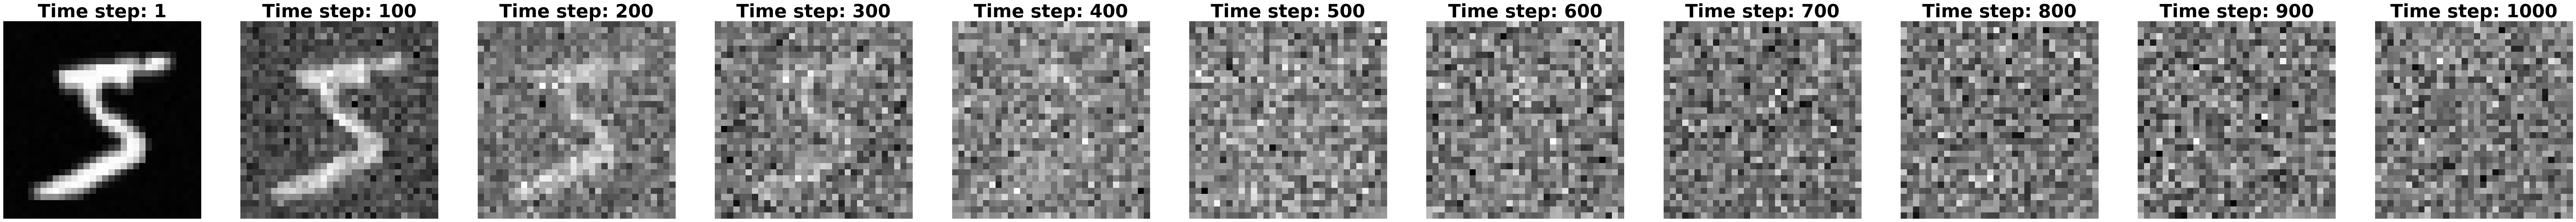

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=40, fontweight='bold')
    ax[idx].axis(False)

### Play with forward parameters

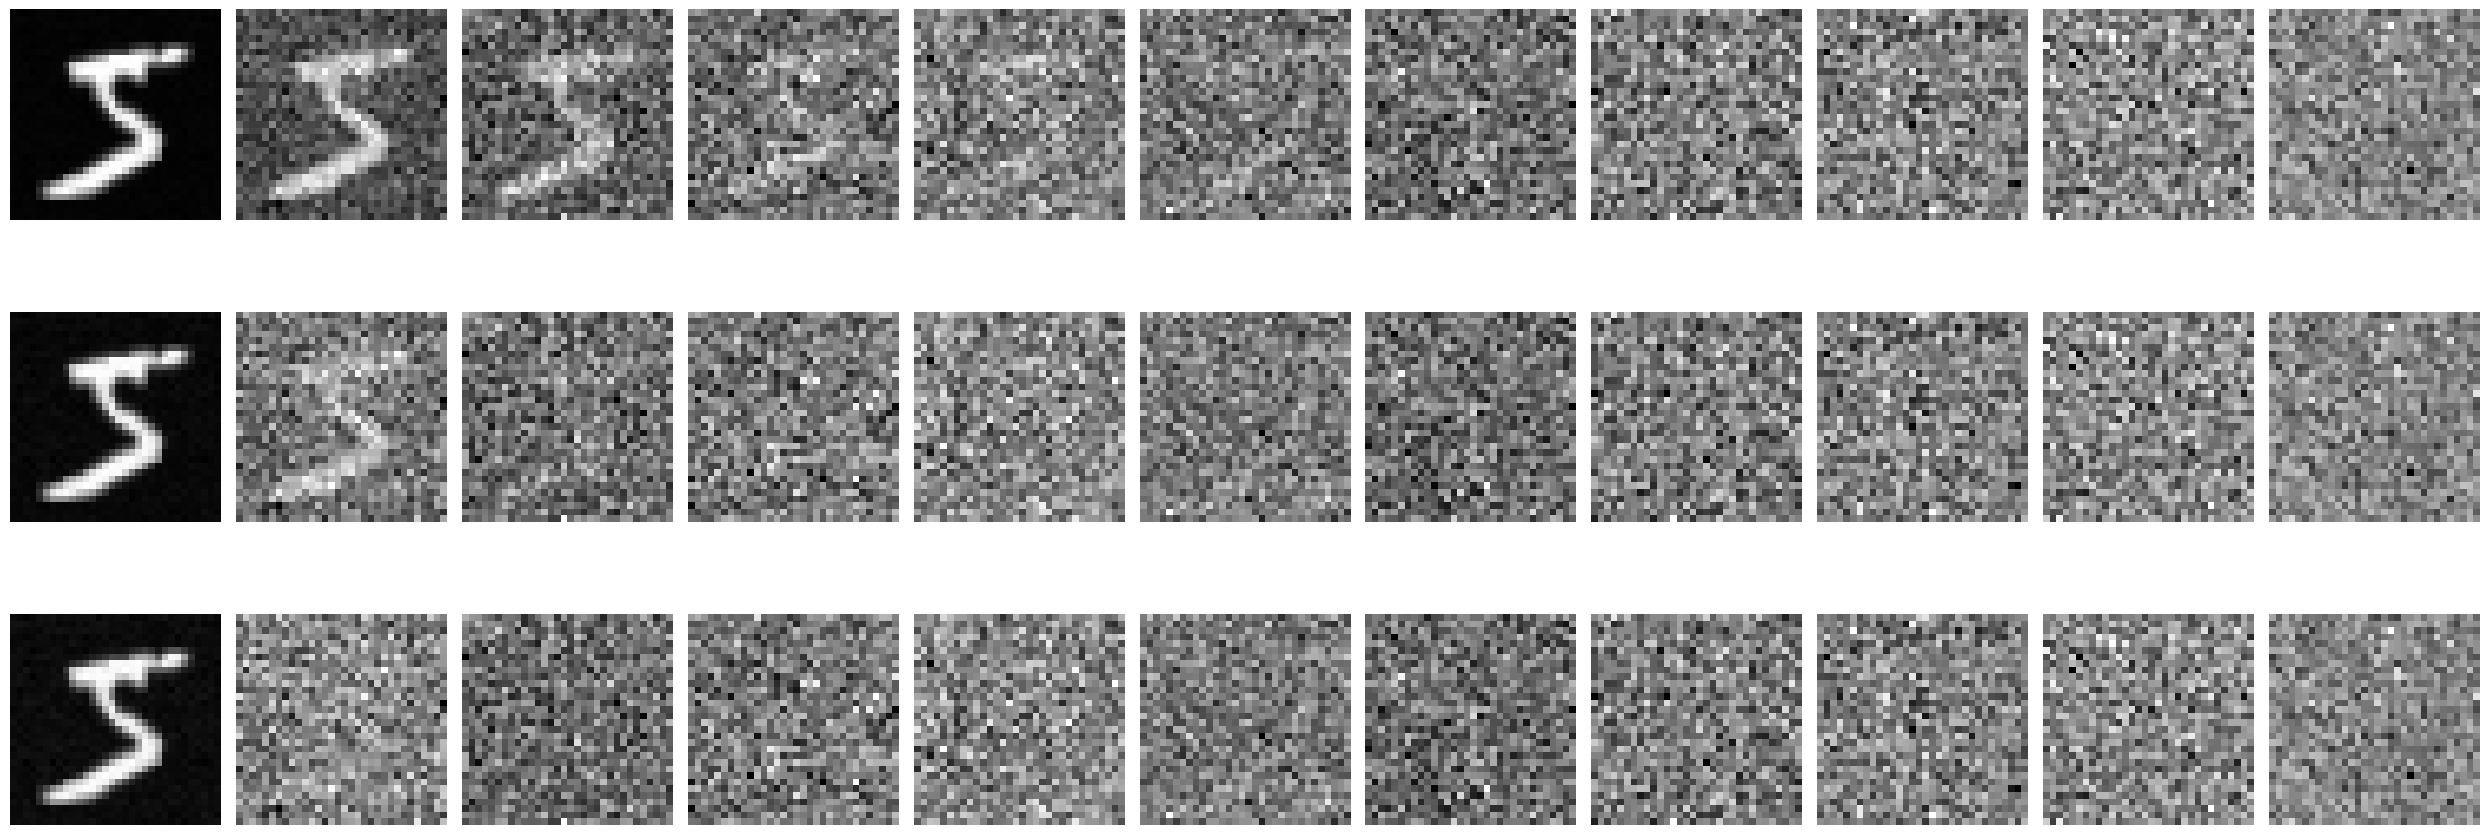

In [14]:
params_list = [
    {'time_steps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02},
    {'time_steps': 500, 'beta_start': 0.0005, 'beta_end': 0.05},
    {'time_steps': 200, 'beta_start': 0.001, 'beta_end': 0.1},
]

# Prepare data
get_img = training_dataset[0][0]
get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()

# Generate noisy images for different parameter settings
fig, axes = plt.subplots(nrows=len(params_list), ncols=11, figsize=(25, 10))

for i, params in enumerate(params_list):
    scheduler = Linear_Variance_Scheduler(time_steps=params['time_steps'],
                                          beta_start=params['beta_start'],
                                          beta_end=params['beta_end'],
                                          device='cpu')
    noisy_img_stack = scheduler.diffusion_process(get_img_stack, get_noise_stack, t_step)
    
    for idx, img in enumerate(noisy_img_stack):
        axes[i, idx].imshow(img.squeeze(), cmap='gray')
        if idx == 0:
            axes[i, idx].set_ylabel(f"Steps: {params['time_steps']}\nBeta: [{params['beta_start']}, {params['beta_end']}]")
        axes[i, idx].axis(False)

plt.tight_layout()
plt.show()

#### U-net Architecture:
- Resblock
- SelfAttentionBlock
- Downblock
- Upblock

# Create ResBlock

In [15]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()
        
        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))
        
    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

# Create SelfAttentionBlock

In [16]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()
        
        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)
        
    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

# Create DownBlock

In [17]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()
        
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UpBlock

In [18]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()
        
        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UNet

In [19]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)
        
        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)
        
        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        
        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

In [20]:
from torchinfo import summary

summary(UNet(t_emb_dim=256), input_size=[(64, 1, 32, 32), (64,)])


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [64, 1, 32, 32]           --
├─ResBlock: 1-1                               [64, 64, 32, 32]          --
│    └─Sequential: 2-1                        [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                       [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                    [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                         [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                       [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                    [64, 64, 32, 32]          128
├─DownBlock: 1-2                              [64, 128, 16, 16]         --
│    └─Sequential: 2-2                        [64, 128, 16, 16]         --
│    │    └─MaxPool2d: 3-6                    [64, 64, 16, 16]          --
│    │    └─ResBlock: 3-7                     [64, 64, 16, 16]          74,112
│    │   

# SET-UP

In [21]:
# ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
# model = UNet(t_emb_dim=256).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# TRAINING

In [22]:

def train(model, criterion, optimizer, ddpm, num_epochs=10):
    torch.manual_seed(1111)
    torch.cuda.manual_seed(1111)
    torch.cuda.manual_seed_all(1111)
    np.random.seed(1111)

    n_epochs = num_epochs
    training_loss, validation_loss = [], []

    for epoch in range(n_epochs):
        training_losses, validation_losses = [], []
        
        for data, _ in tqdm(training_dataloader):
            model.train()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            trng_batch_loss = criterion(noise, pred_noise)
            optimizer.zero_grad()
            trng_batch_loss.backward()
            optimizer.step()
            training_losses.append(trng_batch_loss.item())
        training_per_epoch_loss = np.array(training_losses).mean()
        
        with torch.inference_mode():
            for data, _ in tqdm(validation_dataloader):
                model.eval()
                data = data.to(device)
                t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
                noise = torch.randn_like(data)
                xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
                pred_noise = torch.tensor(model(xt, t))
                tst_batch_loss = criterion(noise, pred_noise)
                validation_losses.append(tst_batch_loss.item())
            validation_per_epoch_loss = np.array(validation_losses).mean()
            
        training_loss.append(training_per_epoch_loss)
        validation_loss.append(validation_per_epoch_loss)
        
        print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
        print(f'Validation loss: {validation_per_epoch_loss:.4f}')
    return training_loss, validation_loss


## EVALUATION

In [23]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_gan as tfgan
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

2024-12-08 10:42:37.287602: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 10:42:37.330482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 10:42:37.330520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 10:42:37.331807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 10:42:37.338908: I tensorflow/core/platform/cpu_feature_guar

In [24]:
# Load the pre-trained MNIST classifier
MNIST_MODULE = "https://tfhub.dev/tensorflow/tfgan/eval/mnist/logits/1"
mnist_classifier_fn = tfhub.load(MNIST_MODULE)


# Define the classifier function
def classifier_fn(images):
    outputs = mnist_classifier_fn(images=images)
    return outputs  # Outputs is a tensor of logits

# Function to compute activations
def compute_activations(images, num_batches, classifier_fn):
    images_list = tf.split(images, num_or_size_splits=num_batches)
    activations = []

    for batch in images_list:
        outputs = classifier_fn(images=batch)
        activations.append(outputs)

    activations = tf.concat(activations, axis=0)

    return activations

# Compute activations for real MNIST images
def load_mnist():
    ds = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.Resize((28, 28)),  # Ensure images are 28x28
            transforms.ToTensor(),
        ]),
    )

    dl = DataLoader(ds, batch_size=60000, shuffle=False)
    x, _ = next(iter(dl))
    x = x.numpy()  # Convert to NumPy array
    x = np.transpose(x, (0, 2, 3, 1))  # Shape: (N, 28, 28, 1)

    return tf.convert_to_tensor(x, dtype=tf.float32)


2024-12-08 10:42:41.776868: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [25]:
model = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20
time_steps_list = [100, 500, 1000]
schedulers = {
    'Linear': Linear_Variance_Scheduler,
    'Cosine': Cosine_Variance_Scheduler,    
    'Sigmoid': Sigmoid_Variance_Scheduler,
}

fid_scores = {scheduler_name: [] for scheduler_name in schedulers.keys()}

for scheduler_name, scheduler_class in schedulers.items():
    for time_steps in time_steps_list:
        scheduler = scheduler_class(time_steps=time_steps)
        training_loss, test_loss = train(model, criterion, optimizer, scheduler, num_epochs)

        sampled_imgs, _ = scheduler.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32)

        # Resize images from 32x32 to 28x28 using PyTorch
        sampled_imgs_resized = F.interpolate(sampled_imgs, size=(28, 28), mode='bilinear', align_corners=False)

        # Process resized images
        sampled_imgs_np = sampled_imgs_resized.cpu().numpy()  # Convert to NumPy array
        sampled_imgs_np = (sampled_imgs_np * 0.5) + 0.5       # Denormalize to [0, 1]
        sampled_imgs_np = np.clip(sampled_imgs_np, 0, 1)      # Ensure values are within [0, 1]
        sampled_imgs_np = np.transpose(sampled_imgs_np, (0, 2, 3, 1))  # Shape: (N, 28, 28, 1)

        # Convert to TensorFlow tensor
        sampled_imgs_tf = tf.convert_to_tensor(sampled_imgs_np, dtype=tf.float32)

        mnist_images_tf = load_mnist()

        # Compute activations for real MNIST images
        activations_real = compute_activations(mnist_images_tf, num_batches=1, classifier_fn=classifier_fn)

        # Compute activations for generated images
        activations_fake = compute_activations(sampled_imgs_tf, num_batches=1, classifier_fn=classifier_fn)

        # Compute FID
        fid = tfgan.eval.frechet_classifier_distance_from_activations(activations_real, activations_fake)

        # print(f"FID: {fid.numpy()}")
        fid_scores[scheduler_name].append(fid.numpy())
        # print(f'Scheduler: {scheduler_name}, FID score: {fid.numpy()}')
        print(f'Scheduler: {scheduler_name}, Time steps: {time_steps}, FID score: {fid.numpy()}')

  0%|          | 0/187 [00:00<?, ?it/s]/tmp/ipykernel_1002356/3960170884.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_noise = torch.tensor(model(xt, t))
100%|██████████| 187/187 [00:06<00:00, 26.87it/s]


Epoch: 1/20	| Training loss: 0.0634 |   Validation loss: 0.0359


100%|██████████| 187/187 [00:06<00:00, 27.05it/s]


Epoch: 2/20	| Training loss: 0.0309 |   Validation loss: 0.0283


100%|██████████| 187/187 [00:06<00:00, 27.07it/s]


Epoch: 3/20	| Training loss: 0.0261 |   Validation loss: 0.0264


100%|██████████| 187/187 [00:06<00:00, 27.11it/s]


Epoch: 4/20	| Training loss: 0.0243 |   Validation loss: 0.0236


100%|██████████| 187/187 [00:06<00:00, 27.10it/s]


Epoch: 5/20	| Training loss: 0.0232 |   Validation loss: 0.0224


100%|██████████| 187/187 [00:06<00:00, 29.47it/s]


Epoch: 6/20	| Training loss: 0.0223 |   Validation loss: 0.0222


100%|██████████| 187/187 [00:06<00:00, 29.49it/s]


Epoch: 7/20	| Training loss: 0.0218 |   Validation loss: 0.0213


100%|██████████| 187/187 [00:06<00:00, 29.49it/s]


Epoch: 8/20	| Training loss: 0.0214 |   Validation loss: 0.0211


100%|██████████| 187/187 [00:06<00:00, 29.49it/s]


Epoch: 9/20	| Training loss: 0.0208 |   Validation loss: 0.0208


100%|██████████| 187/187 [00:06<00:00, 29.54it/s]


Epoch: 10/20	| Training loss: 0.0207 |   Validation loss: 0.0204


100%|██████████| 187/187 [00:06<00:00, 29.56it/s]


Epoch: 11/20	| Training loss: 0.0205 |   Validation loss: 0.0201


100%|██████████| 187/187 [00:06<00:00, 29.55it/s]


Epoch: 12/20	| Training loss: 0.0202 |   Validation loss: 0.0203


100%|██████████| 187/187 [00:06<00:00, 29.56it/s]


Epoch: 13/20	| Training loss: 0.0201 |   Validation loss: 0.0197


100%|██████████| 187/187 [00:06<00:00, 29.54it/s]


Epoch: 14/20	| Training loss: 0.0199 |   Validation loss: 0.0202


100%|██████████| 187/187 [00:06<00:00, 29.54it/s]


Epoch: 15/20	| Training loss: 0.0196 |   Validation loss: 0.0202


100%|██████████| 187/187 [00:06<00:00, 29.57it/s]


Epoch: 16/20	| Training loss: 0.0195 |   Validation loss: 0.0194


100%|██████████| 187/187 [00:06<00:00, 29.56it/s]


Epoch: 17/20	| Training loss: 0.0196 |   Validation loss: 0.0195


100%|██████████| 187/187 [00:06<00:00, 29.59it/s]


Epoch: 18/20	| Training loss: 0.0194 |   Validation loss: 0.0191


100%|██████████| 187/187 [00:06<00:00, 27.96it/s]


Epoch: 19/20	| Training loss: 0.0191 |   Validation loss: 0.0188


100%|██████████| 187/187 [00:06<00:00, 27.24it/s]


Epoch: 20/20	| Training loss: 0.0192 |   Validation loss: 0.0189


100it [00:02, 43.70it/s]


Scheduler: Linear, Time steps: 100, FID score: 28.246713638305664


100%|██████████| 187/187 [00:06<00:00, 27.18it/s]


Epoch: 1/20	| Training loss: 0.0142 |   Validation loss: 0.0137


100%|██████████| 187/187 [00:06<00:00, 27.20it/s]


Epoch: 2/20	| Training loss: 0.0129 |   Validation loss: 0.0129


100%|██████████| 187/187 [00:06<00:00, 27.21it/s]


Epoch: 3/20	| Training loss: 0.0126 |   Validation loss: 0.0125


100%|██████████| 187/187 [00:06<00:00, 27.12it/s]


Epoch: 4/20	| Training loss: 0.0127 |   Validation loss: 0.0126


100%|██████████| 187/187 [00:06<00:00, 27.25it/s]


Epoch: 5/20	| Training loss: 0.0123 |   Validation loss: 0.0124


100%|██████████| 187/187 [00:06<00:00, 27.36it/s]


Epoch: 6/20	| Training loss: 0.0123 |   Validation loss: 0.0129


100%|██████████| 187/187 [00:06<00:00, 27.42it/s]


Epoch: 7/20	| Training loss: 0.0123 |   Validation loss: 0.0122


100%|██████████| 187/187 [00:06<00:00, 29.72it/s]


Epoch: 8/20	| Training loss: 0.0123 |   Validation loss: 0.0124


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 9/20	| Training loss: 0.0121 |   Validation loss: 0.0120


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 10/20	| Training loss: 0.0122 |   Validation loss: 0.0120


100%|██████████| 187/187 [00:06<00:00, 29.75it/s]


Epoch: 11/20	| Training loss: 0.0121 |   Validation loss: 0.0119


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 12/20	| Training loss: 0.0120 |   Validation loss: 0.0120


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 13/20	| Training loss: 0.0121 |   Validation loss: 0.0120


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 14/20	| Training loss: 0.0119 |   Validation loss: 0.0118


100%|██████████| 187/187 [00:06<00:00, 29.75it/s]


Epoch: 15/20	| Training loss: 0.0118 |   Validation loss: 0.0122


100%|██████████| 187/187 [00:06<00:00, 29.76it/s]


Epoch: 16/20	| Training loss: 0.0117 |   Validation loss: 0.0118


100%|██████████| 187/187 [00:06<00:00, 29.76it/s]


Epoch: 17/20	| Training loss: 0.0120 |   Validation loss: 0.0117


100%|██████████| 187/187 [00:06<00:00, 29.74it/s]


Epoch: 18/20	| Training loss: 0.0119 |   Validation loss: 0.0116


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 19/20	| Training loss: 0.0117 |   Validation loss: 0.0113


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 20/20	| Training loss: 0.0118 |   Validation loss: 0.0117


500it [00:11, 44.86it/s]


Scheduler: Linear, Time steps: 500, FID score: 9.23912239074707


100%|██████████| 187/187 [00:06<00:00, 27.43it/s]


Epoch: 1/20	| Training loss: 0.0157 |   Validation loss: 0.0157


100%|██████████| 187/187 [00:06<00:00, 27.43it/s]


Epoch: 2/20	| Training loss: 0.0153 |   Validation loss: 0.0155


100%|██████████| 187/187 [00:06<00:00, 27.42it/s]


Epoch: 3/20	| Training loss: 0.0152 |   Validation loss: 0.0151


100%|██████████| 187/187 [00:06<00:00, 27.44it/s]


Epoch: 4/20	| Training loss: 0.0153 |   Validation loss: 0.0152


100%|██████████| 187/187 [00:06<00:00, 27.45it/s]


Epoch: 5/20	| Training loss: 0.0150 |   Validation loss: 0.0153


100%|██████████| 187/187 [00:06<00:00, 27.47it/s]


Epoch: 6/20	| Training loss: 0.0151 |   Validation loss: 0.0153


100%|██████████| 187/187 [00:06<00:00, 27.47it/s]


Epoch: 7/20	| Training loss: 0.0150 |   Validation loss: 0.0152


100%|██████████| 187/187 [00:06<00:00, 27.47it/s]


Epoch: 8/20	| Training loss: 0.0152 |   Validation loss: 0.0152


100%|██████████| 187/187 [00:06<00:00, 27.47it/s]


Epoch: 9/20	| Training loss: 0.0150 |   Validation loss: 0.0149


100%|██████████| 187/187 [00:06<00:00, 27.48it/s]


Epoch: 10/20	| Training loss: 0.0150 |   Validation loss: 0.0150


100%|██████████| 187/187 [00:06<00:00, 27.46it/s]


Epoch: 11/20	| Training loss: 0.0150 |   Validation loss: 0.0151


100%|██████████| 187/187 [00:06<00:00, 27.47it/s]


Epoch: 12/20	| Training loss: 0.0149 |   Validation loss: 0.0150


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 13/20	| Training loss: 0.0150 |   Validation loss: 0.0150


100%|██████████| 187/187 [00:06<00:00, 29.70it/s]


Epoch: 14/20	| Training loss: 0.0149 |   Validation loss: 0.0149


100%|██████████| 187/187 [00:06<00:00, 29.72it/s]


Epoch: 15/20	| Training loss: 0.0148 |   Validation loss: 0.0153


100%|██████████| 187/187 [00:06<00:00, 29.69it/s]


Epoch: 16/20	| Training loss: 0.0147 |   Validation loss: 0.0150


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 17/20	| Training loss: 0.0150 |   Validation loss: 0.0148


100%|██████████| 187/187 [00:06<00:00, 29.72it/s]


Epoch: 18/20	| Training loss: 0.0149 |   Validation loss: 0.0146


100%|██████████| 187/187 [00:06<00:00, 29.69it/s]


Epoch: 19/20	| Training loss: 0.0147 |   Validation loss: 0.0144


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 20/20	| Training loss: 0.0149 |   Validation loss: 0.0149


1000it [00:22, 44.85it/s]


Scheduler: Linear, Time steps: 1000, FID score: 7.823258399963379


100%|██████████| 187/187 [00:06<00:00, 27.42it/s]


Epoch: 1/20	| Training loss: 0.0047 |   Validation loss: 0.0038


100%|██████████| 187/187 [00:06<00:00, 27.45it/s]


Epoch: 2/20	| Training loss: 0.0038 |   Validation loss: 0.0040


100%|██████████| 187/187 [00:06<00:00, 27.94it/s]


Epoch: 3/20	| Training loss: 0.0038 |   Validation loss: 0.0037


100%|██████████| 187/187 [00:06<00:00, 29.65it/s]


Epoch: 4/20	| Training loss: 0.0038 |   Validation loss: 0.0035


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 5/20	| Training loss: 0.0037 |   Validation loss: 0.0040


100%|██████████| 187/187 [00:06<00:00, 29.66it/s]


Epoch: 6/20	| Training loss: 0.0038 |   Validation loss: 0.0040


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 7/20	| Training loss: 0.0038 |   Validation loss: 0.0038


100%|██████████| 187/187 [00:06<00:00, 29.68it/s]


Epoch: 8/20	| Training loss: 0.0038 |   Validation loss: 0.0036


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 9/20	| Training loss: 0.0034 |   Validation loss: 0.0035


100%|██████████| 187/187 [00:06<00:00, 29.70it/s]


Epoch: 10/20	| Training loss: 0.0038 |   Validation loss: 0.0034


100%|██████████| 187/187 [00:06<00:00, 29.81it/s]


Epoch: 11/20	| Training loss: 0.0037 |   Validation loss: 0.0037


100%|██████████| 187/187 [00:06<00:00, 29.78it/s]


Epoch: 12/20	| Training loss: 0.0036 |   Validation loss: 0.0033


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 13/20	| Training loss: 0.0041 |   Validation loss: 0.0035


100%|██████████| 187/187 [00:06<00:00, 29.74it/s]


Epoch: 14/20	| Training loss: 0.0037 |   Validation loss: 0.0038


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 15/20	| Training loss: 0.0035 |   Validation loss: 0.0038


100%|██████████| 187/187 [00:06<00:00, 29.35it/s]


Epoch: 16/20	| Training loss: 0.0036 |   Validation loss: 0.0038


100%|██████████| 187/187 [00:06<00:00, 29.77it/s]


Epoch: 17/20	| Training loss: 0.0041 |   Validation loss: 0.0040


100%|██████████| 187/187 [00:06<00:00, 29.78it/s]


Epoch: 18/20	| Training loss: 0.0038 |   Validation loss: 0.0039


100%|██████████| 187/187 [00:06<00:00, 29.77it/s]


Epoch: 19/20	| Training loss: 0.0036 |   Validation loss: 0.0028


100%|██████████| 187/187 [00:06<00:00, 29.79it/s]


Epoch: 20/20	| Training loss: 0.0036 |   Validation loss: 0.0036


100it [00:02, 45.17it/s]


Scheduler: Cosine, Time steps: 100, FID score: 3.909358501434326


100%|██████████| 187/187 [00:06<00:00, 29.79it/s]


Epoch: 1/20	| Training loss: 0.0153 |   Validation loss: 0.0145


100%|██████████| 187/187 [00:06<00:00, 29.79it/s]


Epoch: 2/20	| Training loss: 0.0140 |   Validation loss: 0.0144


100%|██████████| 187/187 [00:06<00:00, 29.82it/s]


Epoch: 3/20	| Training loss: 0.0139 |   Validation loss: 0.0137


100%|██████████| 187/187 [00:06<00:00, 29.78it/s]


Epoch: 4/20	| Training loss: 0.0140 |   Validation loss: 0.0136


100%|██████████| 187/187 [00:06<00:00, 29.81it/s]


Epoch: 5/20	| Training loss: 0.0136 |   Validation loss: 0.0140


100%|██████████| 187/187 [00:06<00:00, 29.77it/s]


Epoch: 6/20	| Training loss: 0.0138 |   Validation loss: 0.0140


100%|██████████| 187/187 [00:06<00:00, 29.78it/s]


Epoch: 7/20	| Training loss: 0.0137 |   Validation loss: 0.0141


100%|██████████| 187/187 [00:06<00:00, 29.75it/s]


Epoch: 8/20	| Training loss: 0.0138 |   Validation loss: 0.0138


100%|██████████| 187/187 [00:06<00:00, 29.77it/s]


Epoch: 9/20	| Training loss: 0.0134 |   Validation loss: 0.0135


100%|██████████| 187/187 [00:06<00:00, 29.80it/s]


Epoch: 10/20	| Training loss: 0.0137 |   Validation loss: 0.0135


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 11/20	| Training loss: 0.0136 |   Validation loss: 0.0137


100%|██████████| 187/187 [00:06<00:00, 29.75it/s]


Epoch: 12/20	| Training loss: 0.0135 |   Validation loss: 0.0134


100%|██████████| 187/187 [00:06<00:00, 29.76it/s]


Epoch: 13/20	| Training loss: 0.0140 |   Validation loss: 0.0138


100%|██████████| 187/187 [00:06<00:00, 29.78it/s]


Epoch: 14/20	| Training loss: 0.0136 |   Validation loss: 0.0137


100%|██████████| 187/187 [00:06<00:00, 29.79it/s]


Epoch: 15/20	| Training loss: 0.0133 |   Validation loss: 0.0138


100%|██████████| 187/187 [00:06<00:00, 29.77it/s]


Epoch: 16/20	| Training loss: 0.0134 |   Validation loss: 0.0139


100%|██████████| 187/187 [00:06<00:00, 29.76it/s]


Epoch: 17/20	| Training loss: 0.0140 |   Validation loss: 0.0139


100%|██████████| 187/187 [00:06<00:00, 29.78it/s]


Epoch: 18/20	| Training loss: 0.0137 |   Validation loss: 0.0136


100%|██████████| 187/187 [00:06<00:00, 29.81it/s]


Epoch: 19/20	| Training loss: 0.0134 |   Validation loss: 0.0126


100%|██████████| 187/187 [00:06<00:00, 29.70it/s]


Epoch: 20/20	| Training loss: 0.0136 |   Validation loss: 0.0136


500it [00:11, 44.83it/s]


Scheduler: Cosine, Time steps: 500, FID score: 9.428839683532715


100%|██████████| 187/187 [00:06<00:00, 29.81it/s]


Epoch: 1/20	| Training loss: 0.0274 |   Validation loss: 0.0266


100%|██████████| 187/187 [00:06<00:00, 29.82it/s]


Epoch: 2/20	| Training loss: 0.0260 |   Validation loss: 0.0267


100%|██████████| 187/187 [00:06<00:00, 29.75it/s]


Epoch: 3/20	| Training loss: 0.0259 |   Validation loss: 0.0258


100%|██████████| 187/187 [00:06<00:00, 29.78it/s]


Epoch: 4/20	| Training loss: 0.0261 |   Validation loss: 0.0261


100%|██████████| 187/187 [00:06<00:00, 29.83it/s]


Epoch: 5/20	| Training loss: 0.0257 |   Validation loss: 0.0263


100%|██████████| 187/187 [00:06<00:00, 29.82it/s]


Epoch: 6/20	| Training loss: 0.0259 |   Validation loss: 0.0263


100%|██████████| 187/187 [00:06<00:00, 29.87it/s]


Epoch: 7/20	| Training loss: 0.0258 |   Validation loss: 0.0264


100%|██████████| 187/187 [00:06<00:00, 29.86it/s]


Epoch: 8/20	| Training loss: 0.0258 |   Validation loss: 0.0261


100%|██████████| 187/187 [00:06<00:00, 29.86it/s]


Epoch: 9/20	| Training loss: 0.0254 |   Validation loss: 0.0258


100%|██████████| 187/187 [00:06<00:00, 29.87it/s]


Epoch: 10/20	| Training loss: 0.0258 |   Validation loss: 0.0255


100%|██████████| 187/187 [00:06<00:00, 29.85it/s]


Epoch: 11/20	| Training loss: 0.0256 |   Validation loss: 0.0259


100%|██████████| 187/187 [00:06<00:00, 29.86it/s]


Epoch: 12/20	| Training loss: 0.0256 |   Validation loss: 0.0255


100%|██████████| 187/187 [00:06<00:00, 29.86it/s]


Epoch: 13/20	| Training loss: 0.0260 |   Validation loss: 0.0259


100%|██████████| 187/187 [00:06<00:00, 29.84it/s]


Epoch: 14/20	| Training loss: 0.0257 |   Validation loss: 0.0259


100%|██████████| 187/187 [00:06<00:00, 29.84it/s]


Epoch: 15/20	| Training loss: 0.0254 |   Validation loss: 0.0259


100%|██████████| 187/187 [00:06<00:00, 29.81it/s]


Epoch: 16/20	| Training loss: 0.0254 |   Validation loss: 0.0261


100%|██████████| 187/187 [00:06<00:00, 29.83it/s]


Epoch: 17/20	| Training loss: 0.0261 |   Validation loss: 0.0262


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 18/20	| Training loss: 0.0256 |   Validation loss: 0.0257


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 19/20	| Training loss: 0.0254 |   Validation loss: 0.0249


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 20/20	| Training loss: 0.0256 |   Validation loss: 0.0256


1000it [00:22, 44.85it/s]


Scheduler: Cosine, Time steps: 1000, FID score: 6.736468315124512


100%|██████████| 187/187 [00:06<00:00, 27.45it/s]


Epoch: 1/20	| Training loss: 0.0040 |   Validation loss: 0.0027


100%|██████████| 187/187 [00:06<00:00, 27.48it/s]


Epoch: 2/20	| Training loss: 0.0028 |   Validation loss: 0.0029


100%|██████████| 187/187 [00:06<00:00, 27.50it/s]


Epoch: 3/20	| Training loss: 0.0028 |   Validation loss: 0.0028


100%|██████████| 187/187 [00:06<00:00, 27.50it/s]


Epoch: 4/20	| Training loss: 0.0029 |   Validation loss: 0.0029


100%|██████████| 187/187 [00:06<00:00, 29.79it/s]


Epoch: 5/20	| Training loss: 0.0028 |   Validation loss: 0.0028


100%|██████████| 187/187 [00:06<00:00, 29.81it/s]


Epoch: 6/20	| Training loss: 0.0028 |   Validation loss: 0.0028


100%|██████████| 187/187 [00:06<00:00, 29.82it/s]


Epoch: 7/20	| Training loss: 0.0028 |   Validation loss: 0.0029


100%|██████████| 187/187 [00:06<00:00, 29.79it/s]


Epoch: 8/20	| Training loss: 0.0029 |   Validation loss: 0.0029


100%|██████████| 187/187 [00:06<00:00, 29.79it/s]


Epoch: 9/20	| Training loss: 0.0028 |   Validation loss: 0.0028


100%|██████████| 187/187 [00:06<00:00, 29.83it/s]


Epoch: 10/20	| Training loss: 0.0028 |   Validation loss: 0.0028


100%|██████████| 187/187 [00:06<00:00, 29.81it/s]


Epoch: 11/20	| Training loss: 0.0028 |   Validation loss: 0.0027


100%|██████████| 187/187 [00:06<00:00, 29.82it/s]


Epoch: 12/20	| Training loss: 0.0028 |   Validation loss: 0.0029


100%|██████████| 187/187 [00:06<00:00, 29.81it/s]


Epoch: 13/20	| Training loss: 0.0029 |   Validation loss: 0.0027


100%|██████████| 187/187 [00:06<00:00, 29.76it/s]


Epoch: 14/20	| Training loss: 0.0029 |   Validation loss: 0.0028


100%|██████████| 187/187 [00:06<00:00, 29.79it/s]


Epoch: 15/20	| Training loss: 0.0028 |   Validation loss: 0.0028


100%|██████████| 187/187 [00:06<00:00, 29.76it/s]


Epoch: 16/20	| Training loss: 0.0027 |   Validation loss: 0.0028


100%|██████████| 187/187 [00:06<00:00, 29.72it/s]


Epoch: 17/20	| Training loss: 0.0029 |   Validation loss: 0.0029


100%|██████████| 187/187 [00:06<00:00, 29.73it/s]


Epoch: 18/20	| Training loss: 0.0029 |   Validation loss: 0.0028


100%|██████████| 187/187 [00:06<00:00, 29.74it/s]


Epoch: 19/20	| Training loss: 0.0028 |   Validation loss: 0.0025


100%|██████████| 187/187 [00:06<00:00, 29.72it/s]


Epoch: 20/20	| Training loss: 0.0029 |   Validation loss: 0.0029


100it [00:02, 45.07it/s]


Scheduler: Sigmoid, Time steps: 100, FID score: 7.733739852905273


100%|██████████| 187/187 [00:06<00:00, 27.44it/s]


Epoch: 1/20	| Training loss: 0.0147 |   Validation loss: 0.0140


100%|██████████| 187/187 [00:06<00:00, 27.43it/s]


Epoch: 2/20	| Training loss: 0.0139 |   Validation loss: 0.0144


100%|██████████| 187/187 [00:06<00:00, 27.42it/s]


Epoch: 3/20	| Training loss: 0.0138 |   Validation loss: 0.0139


100%|██████████| 187/187 [00:06<00:00, 27.44it/s]


Epoch: 4/20	| Training loss: 0.0139 |   Validation loss: 0.0139


100%|██████████| 187/187 [00:06<00:00, 29.69it/s]


Epoch: 5/20	| Training loss: 0.0136 |   Validation loss: 0.0139


100%|██████████| 187/187 [00:06<00:00, 29.70it/s]


Epoch: 6/20	| Training loss: 0.0137 |   Validation loss: 0.0139


100%|██████████| 187/187 [00:06<00:00, 29.68it/s]


Epoch: 7/20	| Training loss: 0.0136 |   Validation loss: 0.0140


100%|██████████| 187/187 [00:06<00:00, 29.69it/s]


Epoch: 8/20	| Training loss: 0.0138 |   Validation loss: 0.0140


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 9/20	| Training loss: 0.0137 |   Validation loss: 0.0138


100%|██████████| 187/187 [00:06<00:00, 29.72it/s]


Epoch: 10/20	| Training loss: 0.0136 |   Validation loss: 0.0138


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 11/20	| Training loss: 0.0136 |   Validation loss: 0.0137


100%|██████████| 187/187 [00:06<00:00, 29.67it/s]


Epoch: 12/20	| Training loss: 0.0136 |   Validation loss: 0.0139


100%|██████████| 187/187 [00:06<00:00, 29.70it/s]


Epoch: 13/20	| Training loss: 0.0137 |   Validation loss: 0.0138


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 14/20	| Training loss: 0.0136 |   Validation loss: 0.0136


100%|██████████| 187/187 [00:06<00:00, 29.70it/s]


Epoch: 15/20	| Training loss: 0.0135 |   Validation loss: 0.0139


100%|██████████| 187/187 [00:06<00:00, 29.68it/s]


Epoch: 16/20	| Training loss: 0.0134 |   Validation loss: 0.0139


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 17/20	| Training loss: 0.0137 |   Validation loss: 0.0137


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 18/20	| Training loss: 0.0137 |   Validation loss: 0.0135


100%|██████████| 187/187 [00:06<00:00, 29.69it/s]


Epoch: 19/20	| Training loss: 0.0135 |   Validation loss: 0.0133


100%|██████████| 187/187 [00:06<00:00, 29.69it/s]


Epoch: 20/20	| Training loss: 0.0136 |   Validation loss: 0.0138


500it [00:11, 44.85it/s]


Scheduler: Sigmoid, Time steps: 500, FID score: 4.934281826019287


100%|██████████| 187/187 [00:06<00:00, 27.48it/s]


Epoch: 1/20	| Training loss: 0.0282 |   Validation loss: 0.0276


100%|██████████| 187/187 [00:06<00:00, 27.45it/s]


Epoch: 2/20	| Training loss: 0.0270 |   Validation loss: 0.0278


100%|██████████| 187/187 [00:06<00:00, 27.44it/s]


Epoch: 3/20	| Training loss: 0.0270 |   Validation loss: 0.0272


100%|██████████| 187/187 [00:06<00:00, 27.45it/s]


Epoch: 4/20	| Training loss: 0.0271 |   Validation loss: 0.0274


100%|██████████| 187/187 [00:06<00:00, 27.47it/s]


Epoch: 5/20	| Training loss: 0.0268 |   Validation loss: 0.0274


100%|██████████| 187/187 [00:06<00:00, 27.48it/s]


Epoch: 6/20	| Training loss: 0.0270 |   Validation loss: 0.0272


100%|██████████| 187/187 [00:06<00:00, 27.50it/s]


Epoch: 7/20	| Training loss: 0.0268 |   Validation loss: 0.0277


100%|██████████| 187/187 [00:06<00:00, 27.38it/s]


Epoch: 8/20	| Training loss: 0.0270 |   Validation loss: 0.0275


100%|██████████| 187/187 [00:06<00:00, 27.46it/s]


Epoch: 9/20	| Training loss: 0.0268 |   Validation loss: 0.0273


100%|██████████| 187/187 [00:06<00:00, 27.47it/s]


Epoch: 10/20	| Training loss: 0.0267 |   Validation loss: 0.0271


100%|██████████| 187/187 [00:06<00:00, 27.44it/s]


Epoch: 11/20	| Training loss: 0.0268 |   Validation loss: 0.0273


100%|██████████| 187/187 [00:06<00:00, 27.43it/s]


Epoch: 12/20	| Training loss: 0.0268 |   Validation loss: 0.0273


100%|██████████| 187/187 [00:06<00:00, 29.78it/s]


Epoch: 13/20	| Training loss: 0.0269 |   Validation loss: 0.0273


100%|██████████| 187/187 [00:06<00:00, 29.64it/s]


Epoch: 14/20	| Training loss: 0.0268 |   Validation loss: 0.0270


100%|██████████| 187/187 [00:06<00:00, 29.66it/s]


Epoch: 15/20	| Training loss: 0.0267 |   Validation loss: 0.0273


100%|██████████| 187/187 [00:06<00:00, 29.68it/s]


Epoch: 16/20	| Training loss: 0.0265 |   Validation loss: 0.0273


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 17/20	| Training loss: 0.0269 |   Validation loss: 0.0273


100%|██████████| 187/187 [00:06<00:00, 29.71it/s]


Epoch: 18/20	| Training loss: 0.0268 |   Validation loss: 0.0268


100%|██████████| 187/187 [00:06<00:00, 29.84it/s]


Epoch: 19/20	| Training loss: 0.0266 |   Validation loss: 0.0267


100%|██████████| 187/187 [00:06<00:00, 29.66it/s]


Epoch: 20/20	| Training loss: 0.0268 |   Validation loss: 0.0271


1000it [00:22, 44.84it/s]


Scheduler: Sigmoid, Time steps: 1000, FID score: 5.038726806640625


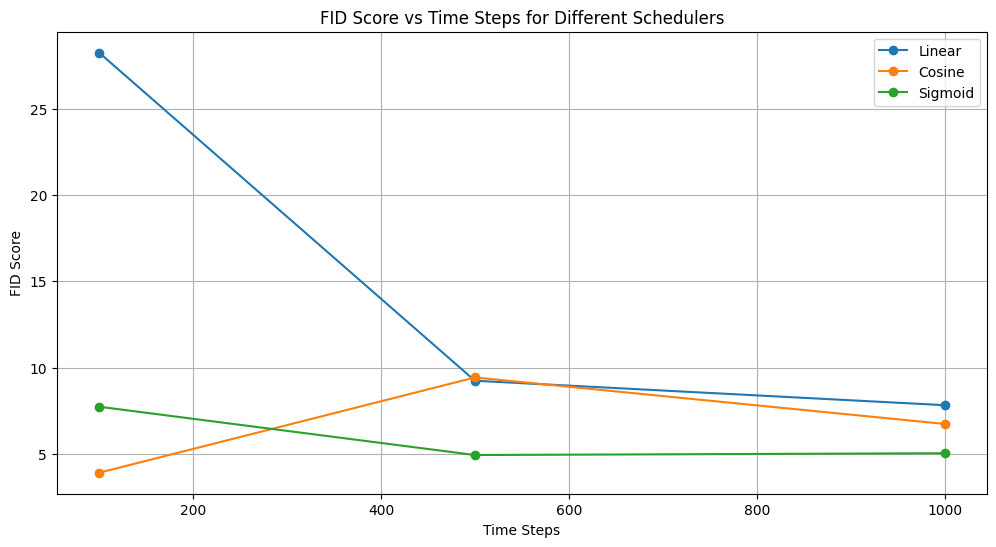

In [26]:

# Plot FID scores
plt.figure(figsize=(12, 6))
for scheduler_name, scores in fid_scores.items():
    plt.plot(time_steps_list, scores, marker='o', label=scheduler_name)
plt.xlabel('Time Steps')
plt.ylabel('FID Score')
plt.title('FID Score vs Time Steps for Different Schedulers')
plt.legend()
plt.grid(True)
plt.show()